In [46]:
#ignorer warnings
import warnings
warnings.filterwarnings("ignore")

In [47]:
import pandas as pd

base_path = "ml-1m/"

ratings = pd.read_csv(
    base_path+"ratings.dat",
    sep="::",
    engine="python",
    names=["UserID", "MovieID", "Rating", "Timestamp"]
)

movies = pd.read_csv(
    base_path+"movies.dat",
    sep="::",
    engine="python",
    names=["MovieID", "Title", "Genres"],
    encoding="latin-1"
)

users = pd.read_csv(
    base_path+"users.dat",
    sep="::",
    engine="python",
    names=["UserID", "Gender", "Age", "Occupation", "Zip-code"]
)

### Statistiques descriptives

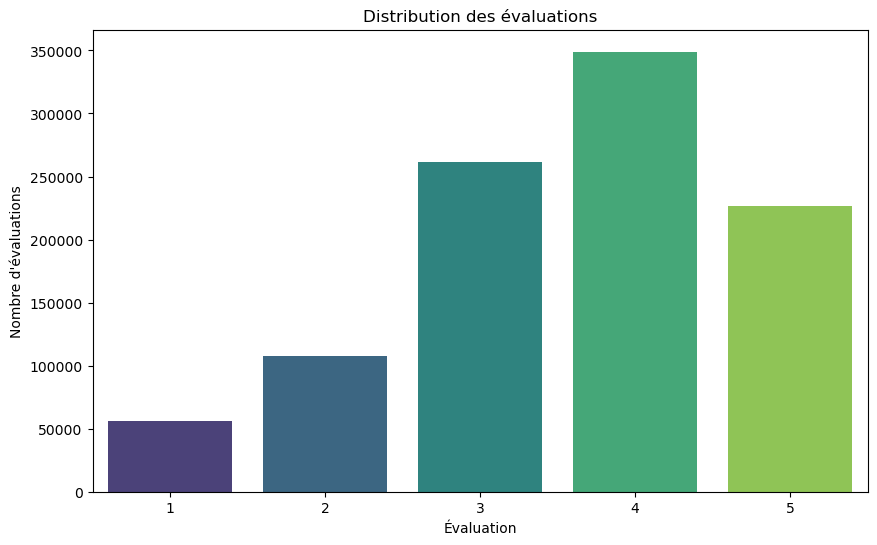

In [ ]:
#diagramme en barres ratings
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.countplot(data=ratings, x='Rating', palette='viridis')

plt.title('Distribution des évaluations')
plt.xlabel('Évaluation')
plt.ylabel('Nombre d\'évaluations')
plt.show()

In [72]:
#moyenne des évaluations
print("Average rating :", ratings.Rating.mean())

Average rating : 3.581564453029317


On voit que les utilisateurs sont généreux sur leurs évaluations. La note la plus attribuée est 4/5, sachant que la note moyenne est 3,53/5 Mais prenons en compte le fait que, pour un même film, un utilisateur peut donner une note différente de celle donnée par un autre. Donc on ne peut pas se fier uniquement sur la notation pour savoir si les deux vont apprécier des films auxquels ils ont attribué une note égale ou même proche (par exemple 3,5 et 4).

In [ ]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter
#nltk.download('stopwords')
#nltk.download('punkt')

## Stats descriptives

## Décomposition en valeurs singulières (SVD)

### 2. Avantages et Inconvénients

#### Points positifs de l'utilisation du SVD sur MovieLens :
1. Réduction de dimensionnalité efficace :
   MovieLens contient beaucoup d’utilisateurs et de films. SVD permet de représenter les interactions utilisateur-film dans un espace latent de plus faible dimension, capturant les préférences implicites.

2. Très bon modèle de base (baseline) : Il sert souvent de référence pour comparer d’autres approches plus complexes (comme les autoencodeurs ou les modèles deep learning).

3. Gère bien la disparité :
La matrice de notation (user × movie) est très creuse. SVD aide à reconstruire les valeurs manquantes en trouvant les patterns sous-jacents.

4. Implémentations efficaces :
Des versions optimisées existent (comme SVD++ dans Surprise, ou des implémentations via scikit-learn ou TensorFlow).

#### Limites et points de vigilance :
1. Besoin d’une matrice "pleine" :
L’algorithme SVD classique nécessite une matrice sans valeurs manquantes. Sur Movielens, on utilise souvent des variantes comme SVD imputation ou SVD sur la matrice factorisée via SGD (ex. : dans Surprise).

2. Pas adapté aux nouveaux utilisateurs ou films (cold start) :
Comme il se base uniquement sur les notations, un nouvel utilisateur (ou un film sans note) ne pourra pas être bien représenté.

3. Pas de prise en compte du contenu :
SVD ne considère pas les métadonnées (genre, âge, description des films...). Pour intégrer ce genre d'info, on part vers des modèles hybrides.



### 3. Définition mathématique

La factorisation de la matrice d'utilité s’appuie sur la décomposition en valeurs singulières (SVD), une technique qui permet d’identifier des structures latentes à partir d’une matrice de notation (utilisateur–item). Cette méthode consiste à décomposer une matrice 𝐴 en trois matrices :

Soit une matrice réelle $A \in \mathbb{R}^{m \times n}$, la décomposition en valeurs singulières (SVD) permet d’écrire :

$$
A = U \Sigma V^T
$$

où :
- $U \in \mathbb{R}^{m \times m}$ est une matrice orthogonale associée aux utilisateurs et aux facteurs latents,
- $V \in \mathbb{R}^{n \times n}$ est une matrice orthogonale contenant les valeurs singulières, qui mesurent l’importance relative de chaque facteur latent,
- $\Sigma \in \mathbb{R}^{m \times n}$ est une matrice diagonale contenant les valeurs singulières $\sigma_1 \geq \sigma_2 \geq \cdots \geq 0$ décrivant la correspondance entre les items et les facteurs latents.

Ces facteurs latents peuvent représenter des caractéristiques implicites des items, comme les genres de films. L’objectif de la SVD est donc de réduire la dimension de la matrice initiale tout en conservant les relations les plus significatives entre utilisateurs et items. Chaque utilisateur et chaque élément est alors projeté dans un espace vectoriel de dimension réduite, facilitant ainsi la modélisation des préférences et la prédiction des évaluations manquantes.

---

In [2]:
import os

import pandas as pd
import numpy as np

import random

# Mesure d'erreur (Erreur moyenne relative)
from sklearn.metrics import mean_squared_error

# SVD
from scipy.sparse.linalg import svds

In [5]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [7]:
movie_count = ratings["MovieID"].nunique()
user_count = ratings['UserID'].nunique()
rating_count = ratings.shape[0]

# Taux de remplissage
rating_pct = rating_count / (user_count * movie_count) * 100

print("#users: "+ str(user_count))
print("#movies: "+ str(movie_count))
print("#ratings %: "+ str(rating_count / (user_count * movie_count) * 100))

print('{:,} ratings of {:,} films rated by {:,} users.'.format(rating_count, movie_count, user_count))

phrase = (
    f"Nous disposons de {user_count:,} utilisateurs et de {movie_count:,} films, "
    f"pour un total de {rating_count:,} notes. "
    f"La matrice utilisateur × film est très creuse, avec seulement {rating_pct:.2f} % "
    f"des couples utilisateur × film renseignés."
)

print(phrase)

# Distribution des notes
p = ratings.groupby('Rating')['Rating'].agg(['count'])

#users: 6040
#movies: 3706
#ratings %: 4.468362562231285
1,000,209 ratings of 3,706 films rated by 6,040 users.
Nous disposons de 6,040 utilisateurs et de 3,706 films, pour un total de 1,000,209 notes. La matrice utilisateur × film est très creuse, avec seulement 4.47 % des couples utilisateur × film renseignés.


###### !pip install seaborn


**On va utiliser le package Surprise**
- documentation : https://surprise.readthedocs.io/en/stable/getting_started.html

Pour utiliser ce package on va devoir transformer le Dataframe en un objet Dataset

In [16]:
ratings.Rating.unique()

array([5, 3, 4, 2, 1], dtype=int64)

On crée un dataset `Surprise` à partir d’un DataFrame Pandas (`ratings` ici), en gardant uniquement les 3 colonnes attendues

On définit l’objet reader en précisant que les notes vont de 1 à 5. Cela permet à Surprise de comprendre l’échelle des ratings

In [8]:
from surprise import SVD, Dataset, Reader

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(ratings[["UserID", "MovieID", "Rating"]], reader)

In [ ]:
# Train set - Test set (75%-25%)
from surprise.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.25, random_state=42) # test set is made of 25% of the ratings.

**_Step 1 : Choosing a model_**

_Modèle simple (SVD par défaut)_

On va commencé par entraîner directement le modèle SVD sur l'ensemble d'entraînement et évaluer sa performance sur l'ensemble de test. Ce processus utilise les hyperparamètres par défaut du modèle SVD sans optimisation

In [ ]:
# Modèle simple (SVD par défaut)
from surprise import Dataset, SVD
algo_simple = SVD()
algo_simple.fit(train_set)

# Prédiction sur train
train_preds_simple = algo_simple.test(train_set.build_testset())

from surprise import accuracy
train_rmse_simple = accuracy.rmse(train_preds_simple, verbose=True)

# Prédiction sur test
test_preds_simple = algo_simple.test(test_set)
test_rmse_simple = accuracy.rmse(test_preds_simple, verbose=True)

print("\n[SVD Simple]")
print(f"Train RMSE : {train_rmse_simple:.4f}")
print(f"Test  RMSE : {test_rmse_simple:.4f}")

RMSE: 0.6698
RMSE: 0.8775

[SVD Simple]
Train RMSE : 0.6698
Test  RMSE : 0.8775


#### SVD optimisé
**GridSearchCV avec Validation Croisée**

Le premier code utilise GridSearchCV, qui teste différentes combinaisons d'hyperparamètres pour optimiser le modèle SVD à l'aide de la validation croisée. Cela signifie que le modèle est testé plusieurs fois sur des sous-ensembles des données et que la performance moyenne est calculée. La validation croisée permet de réduire le risque de surapprentissage (overfitting) et de donner une estimation plus robuste des performances du modèle. 

In [ ]:
# Modèle optimisé avec GridSearchCV
param_grid = {
    "n_epochs": [5, 10],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}

from surprise.model_selection import GridSearchCV
gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)
gs.fit(data)

best_params = gs.best_params['rmse']
algo_grid = SVD(**best_params)
algo_grid.fit(train_set)

# Prédiction sur train
train_preds_grid = algo_grid.test(train_set.build_testset())
train_rmse_grid = accuracy.rmse(train_preds_grid, verbose=True)

# Prédiction sur test
test_preds_grid = algo_grid.test(test_set)
test_rmse_grid = accuracy.rmse(test_preds_grid, verbose=True)

print("\n[SVD Optimisé avec GridSearchCV]")
print(f"Train RMSE : {train_rmse_grid:.4f}")
print(f"Test  RMSE : {test_rmse_grid:.4f}")

RMSE: 0.9202
RMSE: 0.9288

[SVD Optimisé avec GridSearchCV]
Train RMSE : 0.9202
Test  RMSE : 0.9288


#### **Comparaison graphique des SVD**

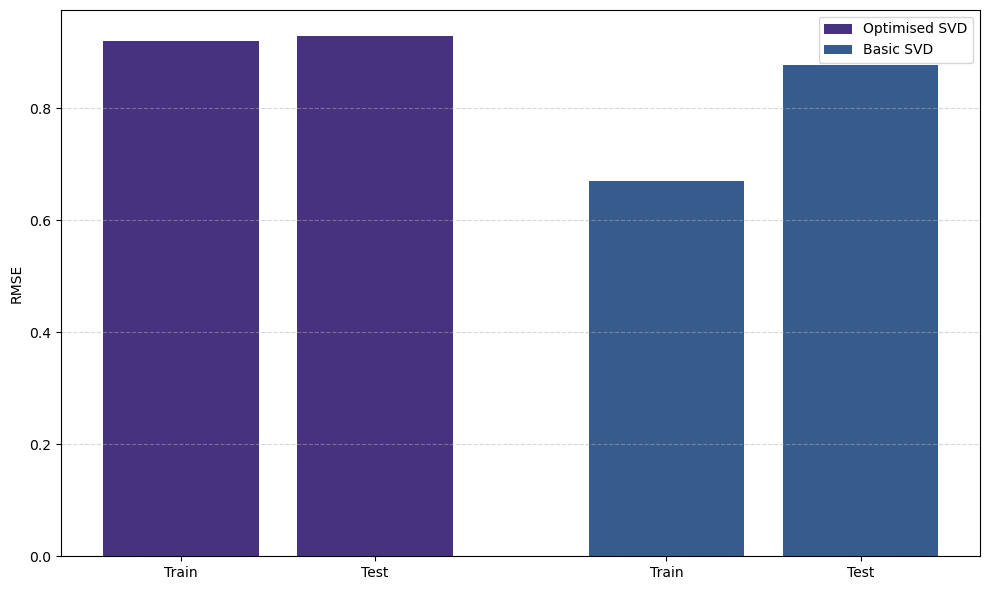

In [76]:
# Préparation des données
rmse_grid = [train_rmse_grid, test_rmse_grid]
rmse_simple = [train_rmse_simple, test_rmse_simple]

labels = ['Train', 'Test']
x = [0, 1]  # positions pour le SVD optimisé
x2 = [i + 2.5 for i in x]  # positions pour le SVD simple

bar_width = 0.8

# Création du graphique
plt.figure(figsize=(10, 6))
sns.set_palette("viridis")
# Barres pour SVD optimisé
plt.bar(x, rmse_grid, width=bar_width, label='Optimised SVD')

# Barres pour SVD simple
plt.bar(x2, rmse_simple, width=bar_width, label='Basic SVD')

# Légendes personnalisées pour les groupes
plt.xticks(ticks=x + x2, labels=['Train', 'Test', 'Train', 'Test'])

# Titres et axes
plt.ylabel('RMSE')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("pdf/rmse_comparison.pdf", format="pdf")
plt.show()

Le modèle SVD simple, avec un RMSE de 0,66 en train mais 0,87 en test, montre un surapprentissage : il apprend très bien les données d’entraînement, mais perd en capacité de généralisation. À l’inverse, le modèle SVD optimisé via GridSearchCV affiche un RMSE identique de 0,92 en train et en test, ce qui témoigne d’une meilleure stabilité et d’une meilleure généralisation, même si la performance brute est légèrement inférieure.

Nous garderons donc le modèle optimisé par GridSearch car même si moins performant il évite le surapprentissage et permet donc de mieux généraliser. Ce qui est idéal pour faire de la recommendation sur de nouveaux utilisateurs

**Etape 2 : Entrainement du modèle**

In [56]:
# Récupérer les meilleurs paramètres
best_params = gs.best_params['rmse']

# Créer un modèle SVD avec ces paramètres
algo = SVD(**best_params)

# Entraîner le modèle
algo.fit(trainset)

**Etape 3. Affichage des films recommandés pour chaque utilisateur**

La fonction get_top_n génère les meilleures recommandations personnalisées pour chaque utilisateur à partir des prédictions faites par notre modèle SVD. Elle prend en entrée une liste de prédictions sous forme de tuples (uid, iid, true_r, est, _) où :

- uid est l'identifiant de l'utilisateur,

- iid est l'identifiant de l'item (film),

- true_r est la note réelle (non utilisée ici),

- est est la note estimée par le modèle,

- _ est une valeur non utilisée dans cette fonction.

Pour chaque utilisateur (uid), la fonction trie les films en fonction de la note estimée (est) et garde les n meilleurs films. Le résultat est un dictionnaire top_n où chaque clé est l'identifiant d'un utilisateur (uid), et la valeur est une liste de tuples (iid, est) contenant l'identifiant des films et leur note estimée, triée par ordre décroissant de la note. Cela permet de fournir les n meilleurs films recommandés pour chaque utilisateur.

In [ ]:
def get_top_n(predictions, n=10):
    '''Pour chaque utilisateur (uid), la fonction trie les films en fonction de la note estimée (est) et garde
        les n meilleurs films. Le résultat est un dictionnaire top_n où chaque clé
        est l'identifiant d'un utilisateur (uid), et la valeur est une liste de tuples (iid, est) contenant
        l'identifiant des films et leur note estimée, triée par ordre décroissant de la note.
        Cela permet de fournir les n meilleurs films recommandés pour chaque utilisateur.'''
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the n highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

In [ ]:
# Predict ratings for the testset                                                                           
predictions = algo.test(testset)

# RMSE
from surprise import accuracy
accuracy.rmse(predictions)
accuracy.mse(predictions)

RMSE: 0.9288
MSE: 0.8627


0.8627150825494273

In [68]:
top_n = get_top_n(predictions, n=10)
top_n.head[,:5]

SyntaxError: invalid syntax (2609711125.py, line 2)

In [ ]:
import pandas as pd

# Créer un dictionnaire MovieID -> Title
movie_dict = pd.Series(movies['Title'].values, index=movies['MovieID']).to_dict()

# Créer une liste pour stocker les recommandations sous forme de ligne par utilisateur
recommandations_list = []

# Limiter à 10 utilisateurs
count = 0
for uid, user_ratings in top_n.items():
    # Extraire les titres des films recommandés
    movie_titles = [movie_dict[iid] for (iid, _) in user_ratings]
    
    # Ajouter cette liste à notre liste de recommandations
    recommandations_list.append([uid] + movie_titles)
    
    count += 1
    if count == 10:  # Arrêter après 10 utilisateurs
        break

# Créer un DataFrame à partir de la liste de recommandations
columns = ['UserID'] + [f'Movie {i+1}' for i in range(len(recommandations_list[0]) - 1)]
recommandations_df = pd.DataFrame(recommandations_list, columns=columns)

recommandations_df

,UserID,Movie 1,Movie 2,Movie 3,Movie 4,Movie 5,Movie 6,Movie 7,Movie 8,Movie 9,Movie 10
0,1263,"Grand Day Out, A (1992)",Life Is Beautiful (La Vita è bella) (1997),"Sting, The (1973)",Young Frankenstein (1974),Gladiator (2000),Apocalypse Now (1979),Pulp Fiction (1994),Butch Cassidy and the Sundance Kid (1969),Raging Bull (1980),This Is Spinal Tap (1984)
1,975,"Sixth Sense, The (1999)","Silence of the Lambs, The (1991)","Princess Bride, The (1987)",Three Colors: Red (1994),Blade Runner (1982),"Boat, The (Das Boot) (1981)","Godfather: Part II, The (1974)",Apocalypse Now (1979),Pulp Fiction (1994),Cool Hand Luke (1967)
2,3929,"Sixth Sense, The (1999)",Saving Private Ryan (1998),American History X (1998),"Matrix, The (1999)","Boat, The (Das Boot) (1981)",Amadeus (1984),Fargo (1996),Star Wars: Episode V - The Empire Strikes Back...,Run Lola Run (Lola rennt) (1998),GoodFellas (1990)
3,1839,"Usual Suspects, The (1995)","Boat, The (Das Boot) (1981)",Almost Famous (2000),"Fugitive, The (1993)",Braveheart (1995),Apollo 13 (1995),Airplane! (1980),Star Wars: Episode VI - Return of the Jedi (1983),"Lion King, The (1994)",Enemy of the State (1998)
4,1499,Saving Private Ryan (1998),Fargo (1996),Terminator 2: Judgment Day (1991),Hamlet (1996),Twelve Monkeys (1995),"Contender, The (2000)",Groundhog Day (1993),Meet the Parents (2000),Titus (1999),Gattaca (1997)
5,3033,"Godfather, The (1972)",Saving Private Ryan (1998),Star Wars: Episode IV - A New Hope (1977),"Princess Bride, The (1987)",Blade Runner (1982),"Matrix, The (1999)",Star Wars: Episode V - The Empire Strikes Back...,Ferris Bueller's Day Off (1986),Die Hard (1988),"Last Emperor, The (1987)"
6,2187,"Shawshank Redemption, The (1994)","Usual Suspects, The (1995)","Sixth Sense, The (1999)",Saving Private Ryan (1998),"Fugitive, The (1993)",Star Wars: Episode V - The Empire Strikes Back...,GoodFellas (1990),Braveheart (1995),Reservoir Dogs (1992),Brazil (1985)
7,1418,Saving Private Ryan (1998),Raiders of the Lost Ark (1981),Star Wars: Episode IV - A New Hope (1977),"Princess Bride, The (1987)","Matrix, The (1999)",Toy Story 2 (1999),Braveheart (1995),Alien (1979),Close Encounters of the Third Kind (1977),Star Wars: Episode VI - Return of the Jedi (1983)
8,3000,American Beauty (1999),Chinatown (1974),"Wizard of Oz, The (1939)","Matrix, The (1999)","Manchurian Candidate, The (1962)",Terminator 2: Judgment Day (1991),"Clockwork Orange, A (1971)",Aliens (1986),Willy Wonka and the Chocolate Factory (1971),Caddyshack (1980)
9,5001,Yojimbo (1961),"General, The (1927)",Star Wars: Episode IV - A New Hope (1977),Rebecca (1940),"Wizard of Oz, The (1939)","Matrix, The (1999)",All About My Mother (Todo Sobre Mi Madre) (1999),Witness (1985),Forrest Gump (1994),"Gay Divorcee, The (1934)"
